<a href="https://colab.research.google.com/github/physicsllama/instrument-detector/blob/main/Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary remarks and ideas


In [ ]:
# other thing: use technique from MIT course to swipe thru song?
#use clustering algorithm to distinguish different instruments!

In [ ]:
''' Some beginning things:

1) Take down data from wav files. Use files containing a single note, played with a pitch fork
and also played with different instruments. Compare the data. Take Fourier transform. Try
to find what note it is from this. Try to deduce instrument playing the note! Normalize stuff to have same volume, same length of audio, etc

samples: notes from different instruments https://philharmonia.co.uk/resources/sound-samples/

2) Take down data from more complicated files (e.g., 5 seconds).

3) Get a sense of how big a neural network I need to represent data from a song
(how many inputs are there?)

4) Process data for set of songs from different genres (e.g. 3 each from classical,
hard rock, pop, and rap)

'''


'''
Useful: https://www.tensorflow.org/io/tutorials/audio

https://www.altexsoft.com/blog/audio-analysis/





Audio sources:
https://freesound.org/browse/packs/?order=-last_updated

https://bigsoundbank.com/search

https://research.google.com/audioset/index.html

'''

'\nUseful: https://www.tensorflow.org/io/tutorials/audio\n\nhttps://www.altexsoft.com/blog/audio-analysis/\n\n\n\n\nAudio sources: \nhttps://freesound.org/browse/packs/?order=-last_updated\n\nhttps://bigsoundbank.com/search\n\nhttps://research.google.com/audioset/index.html\n\n'

Take data and separate into training/testing, and arrange into folders in convenient way. Do both myself manually in Python and with automatic pytorch/whatever thing.

Make sure all audio files same length. Perhaps use only files with normal notes (no trill/tremolo nonsense?) first?

Sine or something for activation functions? Also, pre-process with Fourier? Or do conv neural net? Some Fourier concept in there.

Standard way is to turn into images. Can I come up with something better? [Why are conv nets good for images? What is a similar "goodness" thing we can exploit for the properties of audio? Study conv nets first!]

Now we begin a standard way of analyzing audio in ML (turning clips into spectrograms). I might experiment with other ways later - Shazam seems to have a more clever way to do it, and I can try to find my own methods.

One possibility for instrument detection: maybe it's enough to just take the FFT of a 0.5 or 1 second clip, and the spectral decomposition is enough of a fingerprint?
Then turning this fingerprint into a filter might help us isolate individual instruments in songs!

Along the previous idea: maybe ML thing can be trained on each individual song (after some pre-training?) to separate out its instruments on a case-by-case basis. It takes e.g., a 1 second clip and within that clip tries to identify different fingerprints left by instruments.

Maybe use something with statistical correlations or autocorrelation or something?

OTHER IDEA: make *my own* data set where I use e.g., Logic & a keyboard to make songs. The input will be full songs, the output will be the separated instrument tracks (which I'll have since I made the songs on Logic). Try actual songs and things like that, also just nonsense songs. Many instruments, few instruments, etc.

# Installing dependencies

In [ ]:
#!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 69.1 MB/s 


In [ ]:
!pip uninstall tensorflow
#!pip uninstall tensorflow-io
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from google.colab import drive
import matplotlib.pyplot as plt
import scipy

In [ ]:
#drive.mount('/content/drive')
mainpath = "/content/drive/MyDrive/Music/"
os.chdir(mainpath)
os.getcwd()
os.listdir()

['Songs',
 'Instruments',
 'train_instruments',
 '.ipynb_checkpoints',
 'testing_instruments',
 'test.wav',
 'Music.ipynb']

# Organizing data

In [ ]:
instrumentpath = "Instruments/all-samples/"
os.chdir(instrumentpath)

In [ ]:
instrument_labels = os.listdir()

In [ ]:
os.chdir('./')
os.chdir(mainpath)
os.chdir('Instruments/')

In [ ]:
os.listdir()

['Instruments_train', 'Instruments_test', 'all-samples']

In [ ]:
instrument_labels

['cello',
 'trombone',
 'bassoon',
 'violin',
 'bass clarinet',
 'banjo',
 'clarinet',
 'trumpet',
 'oboe',
 'guitar',
 'contrabassoon',
 'flute',
 'viola',
 'mandolin',
 'double bass',
 'tuba',
 'cor anglais',
 'french horn',
 'percussion',
 'saxophone']

In [ ]:
os.chdir('./')
os.chdir(mainpath)
os.chdir('Instruments/')

for instrument in instrument_labels:
  sounds = os.listdir('all-samples/' + instrument)
  for sound in sounds:
    if sound == '.DS_Store':
      pass
    else:
      soundpath1 = 'all-samples/' + instrument + '/' + sound
      p = np.random.rand()
      if p <= 0.3:
        soundpath2 = 'Instruments_test/' + sound
      else:
        soundpath2 = 'Instruments_train/' + sound
      os.rename(soundpath1, soundpath2)
  print('Moved stuff from ' + instrument + '!')

Moved stuff from cello!
Moved stuff from trombone!
Moved stuff from bassoon!
Moved stuff from violin!
Moved stuff from bass clarinet!
Moved stuff from banjo!
Moved stuff from clarinet!
Moved stuff from trumpet!
Moved stuff from oboe!
Moved stuff from guitar!
Moved stuff from contrabassoon!
Moved stuff from flute!
Moved stuff from viola!
Moved stuff from mandolin!
Moved stuff from double bass!
Moved stuff from tuba!
Moved stuff from cor anglais!
Moved stuff from french horn!
Moved stuff from percussion!
Moved stuff from saxophone!


In [ ]:
os.listdir()

['Instruments_train', 'Instruments_test', 'all-samples']

In [ ]:
os.chdir('Instruments_test')

In [ ]:
len(os.listdir())

4076

In [ ]:
os.chdir('../')

In [ ]:
os.chdir('Instruments_train')

In [ ]:
len(os.listdir())

3

In [ ]:
os.chdir('../')

In [ ]:
#next: delete random folders of percussion and stuff like that that were left over in training and testing. To do this, check that all files in the
#training and testing folders were

# Pre-processing data

In [ ]:
# Function that will make things easier:
def apply_to_set(f, old_set):
  new_set = []
  for i in old_set:
    new_set.append(np.array(f(i)))
  return new_set

In [ ]:
testing_samples = os.listdir('Instruments/Instruments_test/')

In [ ]:
normalnotes_testing = []
for i in testing_samples:
  if i.find('normal')!=-1:
    normalnotes_testing.append(i)
np.save('testing_instruments/testing_labels', normalnotes_testing, allow_pickle='True')

In [ ]:
training_samples = os.listdir('Instruments/Instruments_train/')

In [ ]:
normalnotes_training = []
for i in training_samples:
  if i.find('normal')!=-1:
    normalnotes_training.append(i)
np.save('train_instruments/training_labels', normalnotes_training, allow_pickle='True')

In [ ]:
#make functions nicer later! (add domain and range, as well as function descriptions)
def io_to_array(io_tensor):
  trimmed_tensor = io_tensor[10:]
  squeezed_tensor = tf.squeeze(trimmed_tensor)
  return np.array(squeezed_tensor)

In [ ]:
os.listdir('testing_instruments')

['testing_labels.npy', 'normal_arrays_test.npy']

In [ ]:
testing_arrays = []
for i in range(len(normalnotes_testing)):
  path = 'Instruments/Instruments_test/' + normalnotes_testing[i]
  iofile = tfio.audio.AudioIOTensor(path)
  testing_arrays.append(io_to_array(iofile))
  if i %100 == 0:
    print (str(i) + ' done!')

In [ ]:
np.save('testing_instruments/testing_arrays', testing_arrays, allow_pickle='True')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
training_arrays = []
for i in range(len(normalnotes_training)):
  path = 'Instruments/Instruments_train/' + normalnotes_training[i]
  iofile = tfio.audio.AudioIOTensor(path)
  training_arrays.append(io_to_array(iofile))
  if i %100 == 0:
    print (str(i) + ' done!')

In [ ]:
np.save('train_instruments/training_arrays', training_arrays, allow_pickle='True')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Metadata and selecting useful data

In [ ]:
# Below I first understand the data set. How many of each type of instrument in training? In testing?
# What is the typical audio length for each instrument?

In [ ]:
# Example of how to load a data file: np.load('train_instruments/normal_arrays.npy', allow_pickle=True)

In [ ]:
training_arrays = np.load('train_instruments/training_arrays.npy', allow_pickle=True)
training_labels = np.load('train_instruments/training_labels.npy', allow_pickle = True)
testing_arrays = np.load('testing_instruments/testing_arrays.npy', allow_pickle=True)
testing_labels = np.load('testing_instruments/testing_labels.npy', allow_pickle=True)

In [ ]:
instrument_labels = ['cello',
 'trombone',
 'bassoon',
 'violin',
 'bass-clarinet',
 'banjo',
 'clarinet',
 'trumpet',
 'oboe',
 'guitar',
 'contrabassoon',
 'flute',
 'viola',
 'mandolin',
 'double-bass',
 'tuba',
 'french-horn',
 'saxophone',
 'english-horn']

In [ ]:
# First number in value of dictionary metadata is number of times the instrument is included in the data.
# Second number in value of dictionary is average duration of a clip containing the instrument.
def files_to_metadata(data, labels):
  metadata = {}
  for i in instrument_labels:
    metadata[i] = [0, 0]

  for i in range(len(labels)):
    for j in instrument_labels:
      if labels[i].find(j) == 0:
        metadata[j][0] += 1
        metadata[j][1] += len(data[i])

  for i in instrument_labels:
    assert metadata[i][0] != 0
    metadata[i][1] = int(metadata[i][1]/metadata[i][0])
  return metadata

In [ ]:
testing_metadata = files_to_metadata(testing_arrays, testing_labels)
training_metadata = files_to_metadata(training_arrays, training_labels)

In [ ]:
def longest(data, labels, bound):
  assert len(data) == len(labels)
  restricted_data = []
  restricted_labels = []
  for i in range(len(data)):
    if len(data[i]) > bound:
      restricted_data.append(data[i])
      restricted_labels.append(labels[i])
  return restricted_data, restricted_labels

In [ ]:
longest_testing_arrays, longest_testing_labels = longest(testing_arrays, testing_labels, 44100)
longest_training_arrays, longest_training_labels = longest(training_arrays, training_labels, 44100)

In [ ]:
longest_training_metadata = files_to_metadata(longest_training_arrays, longest_training_labels)
longest_testing_metadata = files_to_metadata(longest_testing_arrays, longest_testing_labels)
longest_training_metadata

{'banjo': [53, 155097],
 'bass-clarinet': [196, 95335],
 'bassoon': [220, 109974],
 'cello': [259, 82800],
 'clarinet': [365, 100548],
 'contrabassoon': [244, 108778],
 'double-bass': [352, 76925],
 'english-horn': [255, 138284],
 'flute': [255, 96884],
 'french-horn': [221, 115700],
 'guitar': [53, 214066],
 'mandolin': [26, 137388],
 'oboe': [211, 73401],
 'saxophone': [120, 122418],
 'trombone': [178, 123409],
 'trumpet': [214, 112213],
 'tuba': [83, 128542],
 'viola': [270, 67659],
 'violin': [320, 66478]}

**Conclusion: if we restrict to a dataset containing only files with at least 44100 samples, we still have decent statistics (>10 for all, and >100 for most). So we'll have a second of audio, and we'll select the second surrounding the peak of the sound.**

In [ ]:
# Note: I explicitly checked that the ordering of the audio files and labels was correct.

# Processing data

In [ ]:
def restricted_audio(audio, duration, rate):
  points = rate * duration
  middle = np.argmax(audio)
  begin = int(middle-points/2)
  end = int(middle+points/2)
  if begin < 0:
    begin = 0
    end = int(points)
  if end >= len(audio):
    begin = len(audio) - int(points)
  return audio[begin:end]

In [ ]:
def trim_data(data, duration, rate):
  trimmed = []
  for i in data:
    trimmed.append(restricted_audio(i, duration, rate))
  return trimmed

In [ ]:
long_training_data = trim_data(longest_training_arrays, 1, 44100)
short_training_data = trim_data(longest_training_arrays, 0.2, 44100)
long_testing_data = trim_data(longest_testing_arrays, 1, 44100)
short_testing_data = trim_data(longest_testing_arrays, 0.2, 44100)

In [ ]:
# Now normalize data:
def normalize(data):
  return (data - np.ones(len(data))*np.mean(data) / np.std(data)) / np.max(data)

In [ ]:
training_long_norm = apply_to_set(normalize, long_training_data)
training_short_norm = apply_to_set(normalize, short_training_data)
testing_long_norm = apply_to_set(normalize, long_testing_data)
testing_short_norm = apply_to_set(normalize, short_testing_data)

In [ ]:
os.listdir()

['Songs',
 'Instruments',
 'train_instruments',
 '.ipynb_checkpoints',
 'testing_instruments',
 'Music.ipynb',
 'test1.wav']

In [ ]:
np.save('train_instruments/long_data_raw', training_long_norm, allow_pickle=True)
np.save('train_instruments/short_data_raw', training_short_norm, allow_pickle=True)
np.save('testing_instruments/long_data_raw', testing_long_norm, allow_pickle=True)
np.save('testing_instruments/short_data_raw', testing_short_norm, allow_pickle=True)

In [ ]:
np.save('testing_instruments/final_labels', longest_testing_labels, allow_pickle=True)
np.save('train_instruments/final_labels', longest_training_labels, allow_pickle=True)

# Fourier transforms (and spectrograms?)

In [ ]:
training_long = np.load('train_instruments/long_data_raw.npy', allow_pickle=True)
training_short = np.load('train_instruments/short_data_raw.npy', allow_pickle=True)
testing_long = np.load('testing_instruments/long_data_raw.npy', allow_pickle=True)
testing_short = np.load('testing_instruments/short_data_raw.npy', allow_pickle=True)

training_labels = np.load('train_instruments/final_labels.npy', allow_pickle=True)
testing_labels = np.load('testing_instruments/final_labels.npy', allow_pickle=True)

In [ ]:
# let's turn one of the small clips into a Fourier mode. The decomposition should be for sines/cosines.
# basic check we can do is that the leading frequency corresponds to the note correctly!

In [ ]:
# we'll pick the tenth guy. this is D note, which is 293.7 Hz, or 288.3 maybe.

# https://pages.mtu.edu/~suits/notefreq432.html

In [ ]:
rate = 44100

In [ ]:
training_labels[270]

'double-bass_As2_15_molto-pianissimo_arco-normal.mp3'

115.0


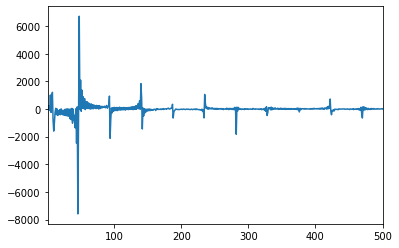

In [ ]:
x = np.array(training_short[270])
r = np.arange(0,len(x))
y = scipy.fft.dct(x)
plt.xlim(1, 500)
plt.plot(r,y)
#print(np.argmax(y))
print(np.argmax(abs(y)) * rate /(2*len(x)))
#print(590/288)

In [ ]:
#from looking at data above, it seems that the Fourier decomposition works relatively well, and correctly picks out the note in almost all cases.
#NOTE: in some cases, for a reason I don't yet understand (e.g. in instrument 10 - violin_D4_1_piano_arco-normal.mp3) it picks out a frequency which is TWICE as large?
#eventually try to run above analysis on entire dataset!

In [ ]:
def data_to_fourier(data):
  x = np.array(data)
  return scipy.fft.dct(x)

fourier_training = apply_to_set(data_to_fourier, training_short)
fourier_testing = apply_to_set(data_to_fourier, testing_short)

In [ ]:
def strip_zero_modes(data):
  return np.delete(data, [0,1])

fourier_training = apply_to_set(strip_zero_modes, fourier_training)
fourier_testing = apply_to_set(strip_zero_modes, fourier_testing)

In [ ]:
# Lastly, we need to normalize (or standardize) the data.
fourier_training = apply_to_set(normalize, fourier_training)
fourier_testing = apply_to_set(normalize, fourier_testing)

In [ ]:
np.save('train_instruments/fourier_training', fourier_training, allow_pickle=True)
np.save('testing_instruments/fourier_testing', fourier_testing, allow_pickle=True)

In [ ]:
def raw_to_spectro(data):
  return tfio.audio.spectrogram(data, nfft=512, window=512, stride=256)

training_spectrograms = apply_to_set(raw_to_spectro, training_long)
testing_spectrograms = apply_to_set(raw_to_spectro, testing_long)

In [ ]:
np.save('train_instruments/training_spectrograms', training_spectrograms, allow_pickle=True)
np.save('testing_instruments/testing_spectrograms', testing_spectrograms, allow_pickle=True)

In [ ]:
def file_to_instrument(file):
  instrument = ''
  for i in file:
    if i == '_':
      break
    else:
      instrument += i
  return instrument

training_labels_instruments_array = apply_to_set(file_to_instrument, training_labels)
testing_labels_instruments_array = apply_to_set(file_to_instrument, testing_labels)

training_labels_instruments = [str(i) for i in training_labels_instruments_array]
testing_labels_instruments = [str(i) for i in testing_labels_instruments_array]

np.save('train_instruments/instrument_labels_train', training_labels_instruments, allow_pickle=True)
np.save('testing_instruments/instrument_labels_test', testing_labels_instruments, allow_pickle=True)

# Defining the model

6) Run analysis on: (maybe keep in mind to randomize order in which I feed data, e.g., not all violins in a row?)
(a) Raw files
(b) Fouriers
(c) Spectrograms

7) Try above with different architectures, experiment!

8) See if I can come up with a different way to analyze the data

9) Fingerprint of instruments? Generalize to other project if possible (of separating out instruments)

10) ML experiments: see what happens as I change size of data set. How much data did I actually need? How does this vary as I change algorithms?

In [ ]:
#load data

In [ ]:
training_long = np.load('train_instruments/long_data_raw.npy', allow_pickle=True)
training_short = np.load('train_instruments/short_data_raw.npy', allow_pickle=True)
training_fourier = np.load('train_instruments/fourier_training.npy', allow_pickle=True)
training_spectro = np.load('train_instruments/training_spectrograms.npy', allow_pickle=True)

testing_long = np.load('testing_instruments/long_data_raw.npy', allow_pickle=True)
testing_short = np.load('testing_instruments/short_data_raw.npy', allow_pickle=True)
testing_fourier = np.load('testing_instruments/fourier_testing.npy', allow_pickle=True)
testing_spectro = np.load('testing_instruments/testing_spectrograms.npy', allow_pickle=True)


train_labels_inst = np.load('train_instruments/instrument_labels_train.npy', allow_pickle=True)
test_labels_inst = np.load('testing_instruments/instrument_labels_test.npy', allow_pickle=True)

In [ ]:
#keep in mind: spectrograms not normalized yet!

In [ ]:
#first we'll do analysis on *fouriers* for simplicity. afterwards we'll try it on raw files and on spectrograms

In [ ]:
#one-hot-encoding

In [ ]:
length = len(training_fourier[0])
instruments = list(set(train_labels_inst))
num_instruments = len(onehot_training[0])

In [ ]:
one_hot = {}
for i in range(len(instruments)):
  vec = np.zeros(len(instruments))
  vec[i] = 1
  one_hot[instruments[i]] = vec

def label_to_onehot(label):
  return one_hot[label]

def value_to_key(value, dic):
  for a in list(dic.items()):
    if list(a[1])==list(value):
      return a[0]

def onehot_to_label(onehot):
  return value_to_key(onehot, one_hot)

In [ ]:
onehot_training = apply_to_set(label_to_onehot, train_labels_inst)
onehot_testing = apply_to_set(label_to_onehot, test_labels_inst)

In [ ]:
#fit model! also maybe use CNN for model no. 2.
onehot_training = np.array(onehot_training)
training_fourier = np.array(training_fourier)

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(length),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_instruments, activation='relu')
])

In [ ]:
model_1.compile(optimizer='adam',
                        loss='mse')

In [ ]:
model_1.fit(training_fourier, onehot_training)

(3895, 19)
(3895, 8818)
122/122 [==============================] - 75s 566ms/step - loss: 0.0493


In [ ]:
np.array(model_1(np.array([testing_fourier[1],testing_fourier[2]]))[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04186781, 0.        , 0.        , 0.        , 0.00061154,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [ ]:
onehot_testing[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
#additionally: try to LEARN the notes with ML. Maybe the ML algorithm will perform better on weird things like file 10 at recognizing the note :).

In [ ]:
#with fourier, try to find all relevant (maybe like 5?) peaks and analyze them.
#i'm guessing I can turn the 5-7 main peaks into an array and THAT data should also be enough for instruments? try that as a set of data as well!
#see if ML can recognize the above point; i.e., how many effective nodes is it really using? try dropout, etc. to identify how many variables go into an instrument :).
#for recognition it might be best to do small sample around biggest frequency? to pick up timbre with that.